# Chargement des librairies

In [1]:
# import librairies
import numpy as np
import time
from scipy.stats import norm
from scipy import meshgrid, zeros, linspace, ones, linalg
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

# Définition des paramètres du Call 

In [2]:
#Strike
K =20 ;

#Maturité
T = 90/360;

#rendement
r = 0.01;

#volatilite
sigma = 0.15;

#Pour le changement de variable
q = 2*r/(sigma**2);

alpha = (1-q)/2;

beta = (-1/4)*(1+q)**2;






# Nombre de points et CFL

In [3]:
# paramètres
N = 200
M = 230
#dtau
tau_ini = 0;
tau_final =(sigma**2) * T/2
dtau = (tau_final - tau_ini)/M;
########################################
tau = np.linspace(tau_ini,tau_final,M);
#tau= np.arange(tau_ini,tau_final,dtau)
#dx
dimEspace = 2*N;
x_ini = -1
x_fin = 1;
dx = abs((x_fin - x_ini))/dimEspace;
#######################################""
x=np.linspace(-N*dx, N*dx,2*N)
#x = np.arange(-N*dx, N*dx, dx)
# CFL ? / paramètre alpha
rapport = dtau/dx**2
print (rapport)

0.48913043478260865


# Fonction de changement de variable

In [4]:
#prix de l'actif

def prixactif(x):
    s = K*np.exp(x)
    return s

#temps
def temps(tau):
    t = T - 2*tau/(sigma**2)
    return t

#retour de l'équation de chaleur vers  black and scholes 
def retour_black_scholes(U,x,M,N,tau,alpha,beta):
    v=np.zeros((M,2*N))
    for i in range(0, M):
        for j in range(0,2*N):
            v[i,j] = K * np.exp(alpha * x[j] + beta * tau[i]) * U[i,j]
            
    return v 


### Initialisation  

In [5]:
def u_initialisation(x):
    U=np.zeros(2*N)
    for j in range(0, (2*N)-1):
        U[j]= np.exp(-alpha*x[j])*max(np.exp(x[j])-1,0)
    return U

# Equation analytique

In [6]:

def calcul_equation_analytique(K,x,sigma,tau,r,T):
    S0=prixactif(x)
    tempss=temps(tau)
    if( tempss == T):
        u = max(S0-K, 0)
    else:
        d1=(np.log(S0/K)+(r+0.5*sigma**2)*(T-tempss)) / (sigma * np.sqrt(T-tempss))
        d2=d1-sigma*np.sqrt((T-tempss))
        nd1=norm.cdf(d1)
        nd2=norm.cdf(d2)
        u=(S0*nd1)-(K*np.exp(-r*(T-tempss))*nd2)
    return u   
    
  

### Matrice A pour explicte et implicite

In [7]:
# matrice Delta et A explicite
Delta_explicite = (np.diag(-2*np.ones(2*N))+np.diag(np.ones(2*N-1),1)+np.diag(np.ones(2*N-1),-1))
A_explicite = np.eye(2*N)+rapport*Delta_explicite

#matrice Delta et A implicite
Delta_implicite = (np.diag(2*np.ones(2*N))+np.diag(-1*np.ones(2*N-1),1)+np.diag(-1*np.ones(2*N-1),-1))
A_implicite = np.eye(2*N)+rapport*Delta_implicite

### Fonction calcule schema euler explicite

In [8]:
def eulerexplicite(x,M,N):
    U=np.zeros((M,2*N))
    U[0,:]=u_initialisation(x)
    U[0,2*N-1]=U[0,2*N-2]
    
    for i in range(1,M):
        U[i,:]=np.dot(A_explicite,U[i-1,:])
        U[i,2*N-1]=(np.exp(x[2*N-1]) - np.exp(-r*(T-tau[i]))) * np.exp(-alpha * x[2*N-1] - beta * tau[i])
    return U 

#### Graphique du Schema explicite

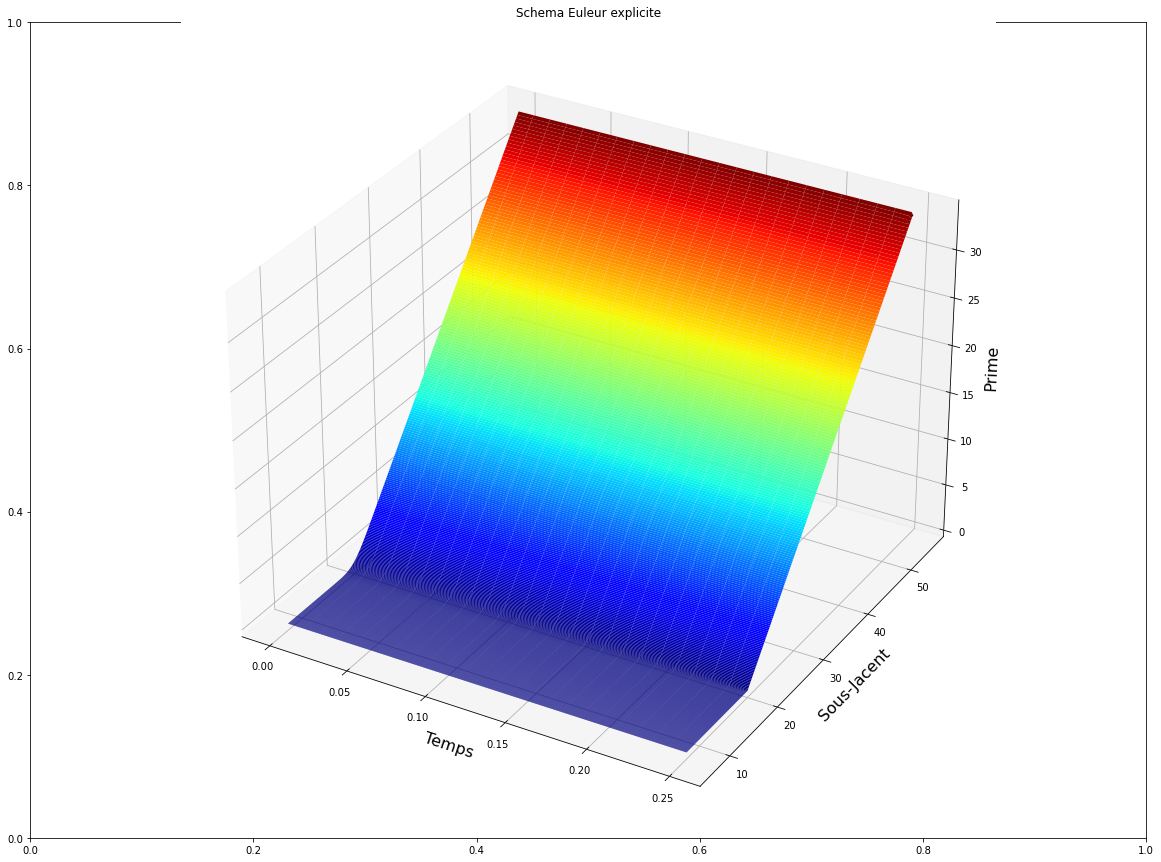

In [9]:

SX,ST = np.meshgrid(prixactif(x),temps(tau))
Uexplicite=eulerexplicite(x,M,N)

V_explicite=retour_black_scholes(Uexplicite,x,M,N,tau,alpha,beta)

fig = plt.figure(figsize=(20,15))
plt.title("Schema Euleur explicite")
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Temps', fontsize = 16)
ax.set_ylabel('Sous-Jacent', fontsize = 16)
ax.set_zlabel('Prime', fontsize = 16)
p = ax.plot_surface(ST,SX,V_explicite,cstride=1,linewidth=0,cmap='jet')

### Fonction calcule schema euler implicite

In [10]:
def eulerimplicite(x,M,N):
    U=np.zeros((M,2*N))
    U[0,:]=u_initialisation(x)
    A_1 = np.linalg.inv(A_implicite)
    for i in range(1,M):
        for j in range(0,2*N-1):
            U[i,:]=np.dot(A_1,U[i-1,:])
            X=rapport*(np.exp(x[2*N-1]) - np.exp(-r*(T-tau[i]))) * np.exp(-alpha * x[2*N-1] - beta * tau[i])
            U[i,2*N-1]=X
    return U 

#### Graphique du Schema implicite

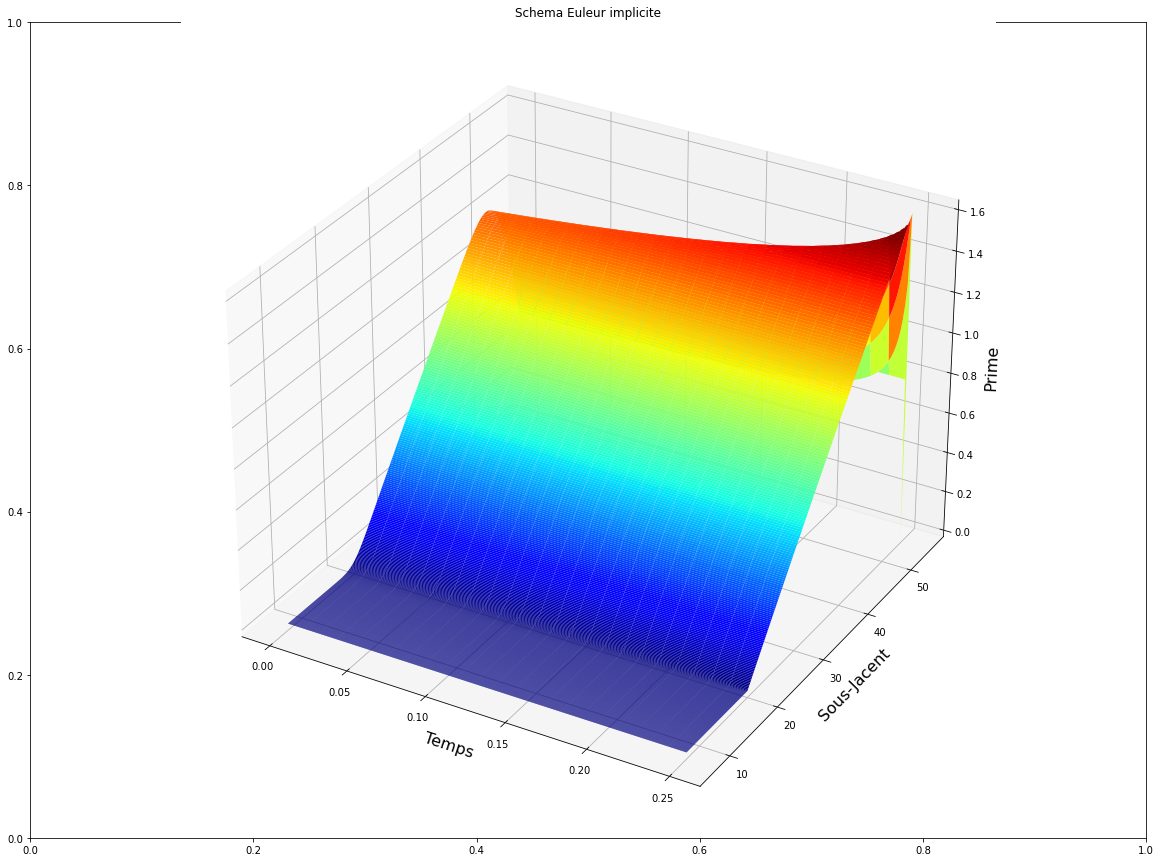

In [11]:

SX,ST = np.meshgrid(prixactif(x),temps(tau))
Uimplicite=eulerimplicite(x,M,N)

V_implicite=retour_black_scholes(Uimplicite,x,M,N,tau,alpha,beta)

fig = plt.figure(figsize=(20,15))
plt.title("Schema Euleur implicite")
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Temps', fontsize = 16)
ax.set_ylabel('Sous-Jacent', fontsize = 16)
ax.set_zlabel('Prime', fontsize = 16)
p = ax.plot_surface(ST,SX,Uimplicite,cstride=1,linewidth=0,cmap='jet')

# <font color=red>Problème aux conditions au bord puisque on a inversé la matrice</font>

### Fonction calcule schema de Cranck Nicolson

In [12]:
def crancknicolson(x,M,N):
    U=np.zeros((M,2*N))
    U[0,:]=u_initialisation(x)
    A1 = np.eye(2*N)+0.5*rapport*Delta_explicite
    A2 = np.eye(2*N)-0.5*rapport*Delta_implicite
    invA2=np.linalg.inv(A2)
    for i in range(1,M):
        U[i,:]=np.dot(np.dot(A1,invA2),U[i-1,:])
        U[i,2*N-1]=(np.exp(x[2*N-1]) - np.exp(-r*(T-tau[i]))) * np.exp(-alpha * x[2*N-1] - beta * tau[i])
    return U 


### Définition de Smax et Smin

In [13]:
S_max=prixactif(x[2*N-1])
S_min=prixactif(x[0])
print(S_max)
print(S_min)

54.3656365691809
7.357588823428847


#### Graphique du Schema Cranck Nicolson

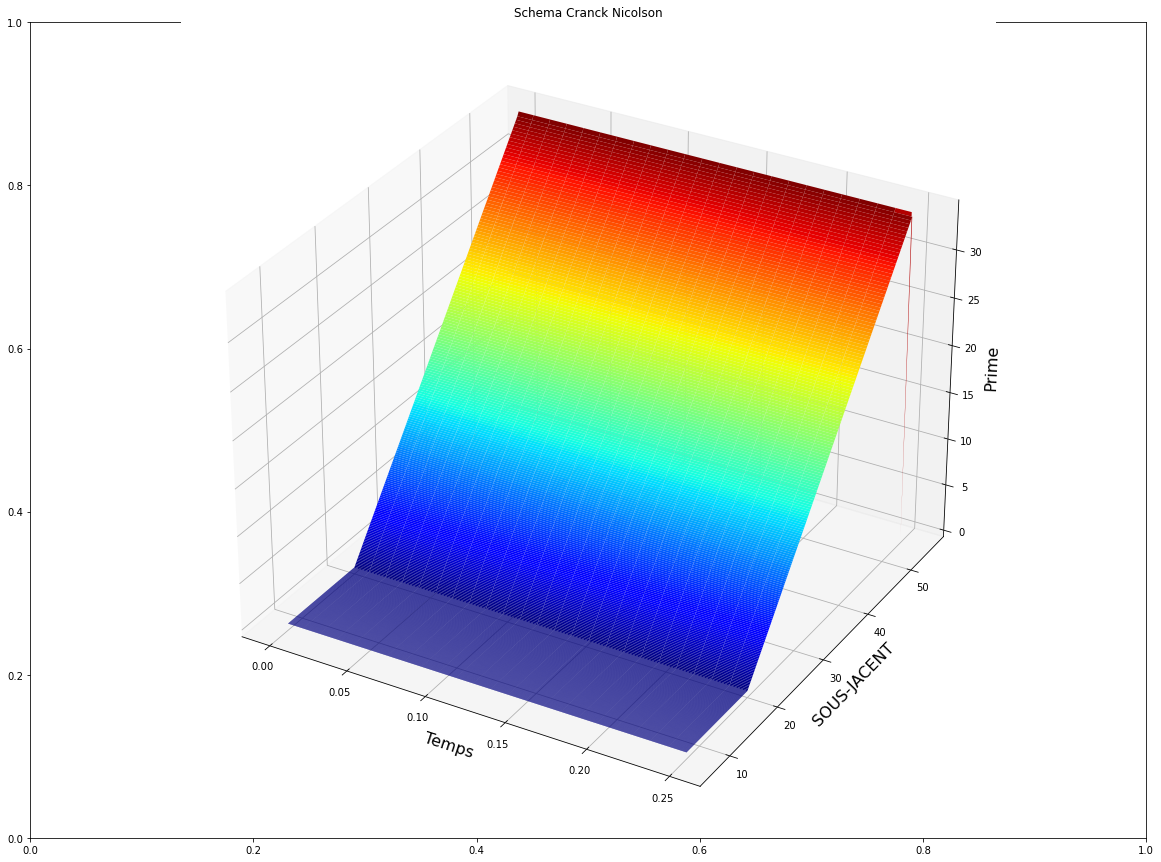

In [14]:
SX,ST = np.meshgrid(prixactif(x),temps(tau))
Ucranck=crancknicolson(x,M,N)  
V_Cranck=retour_black_scholes(Ucranck,x,M,N,tau,alpha,beta)
fig = plt.figure(figsize=(20,15))
plt.title("Schema Cranck Nicolson")
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Temps', fontsize = 16)
ax.set_ylabel('SOUS-JACENT', fontsize = 16)
ax.set_zlabel('Prime', fontsize = 16)
p = ax.plot_surface(ST,SX,V_Cranck,cstride=1,linewidth=0,cmap='jet')
plt.show()

#### Graphique de l'equation analytique

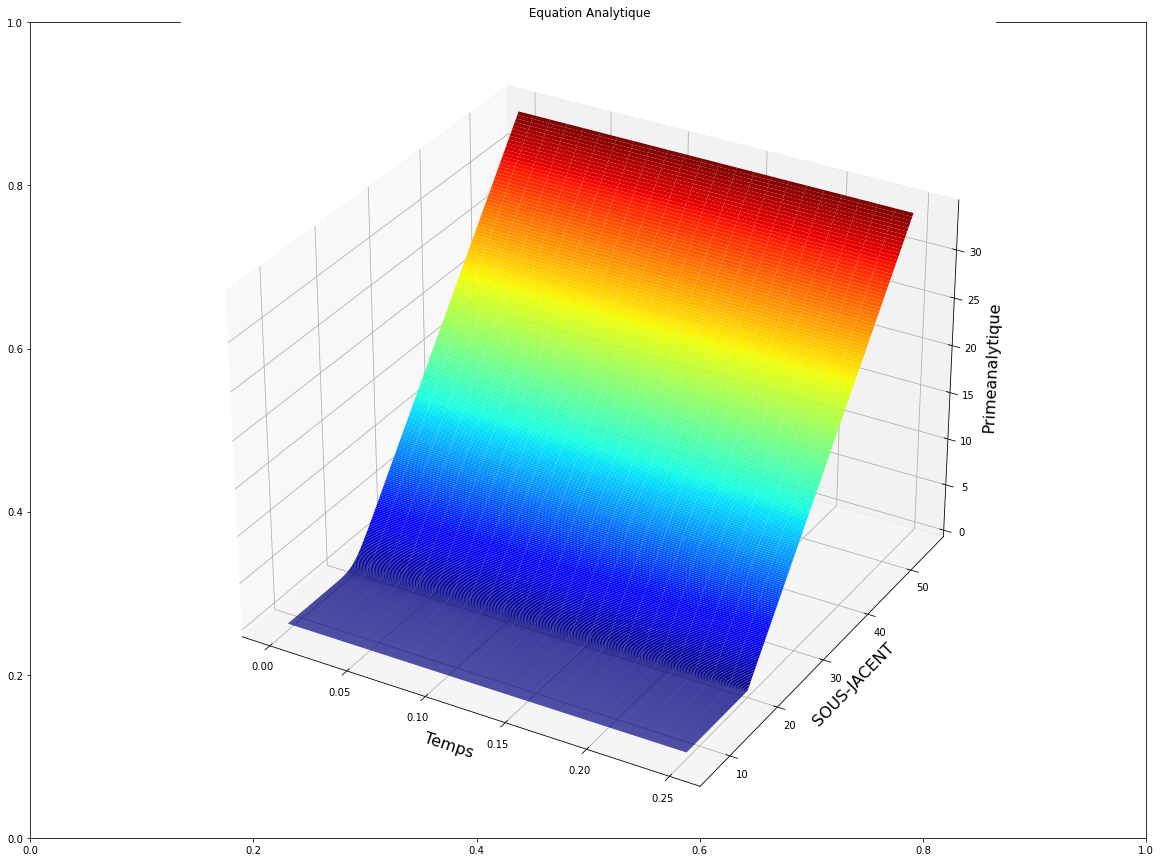

In [15]:
analytique=np.zeros((M,2*N))
for i in range (0,M):
    for j in range (0,2*N):
        analytique[i,j] = calcul_equation_analytique(K,x[j],sigma,tau[i],r,T)

SX,ST = np.meshgrid(prixactif(x),temps(tau))     
fig = plt.figure(figsize=(20,15))
plt.title(" Equation Analytique")
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Temps', fontsize = 16)
ax.set_ylabel('SOUS-JACENT', fontsize = 16)
ax.set_zlabel('Primeanalytique', fontsize = 16)
p = ax.plot_surface(ST,SX,analytique,cstride=1,linewidth=0,cmap='jet')


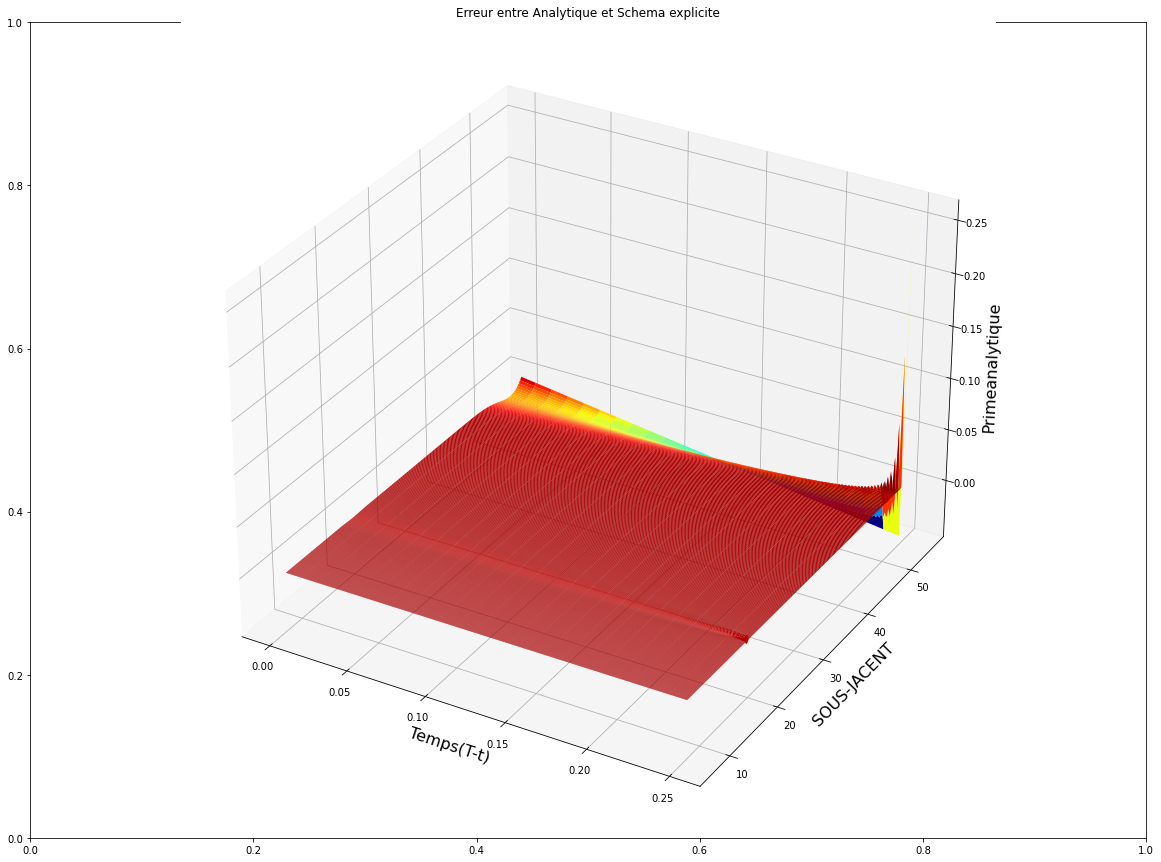

In [16]:
fig = plt.figure(figsize=(20,15))
plt.title("Erreur entre Analytique et Schema explicite")
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Temps(T-t)', fontsize = 16)
ax.set_ylabel('SOUS-JACENT', fontsize = 16)
ax.set_zlabel('Primeanalytique', fontsize = 16)

p = ax.plot_surface(ST,SX,analytique-V_explicite,cstride=1,linewidth=0,cmap='jet')


# Visualisation de l'erreur entre Schema explicite et l'analytique en fonction du S:

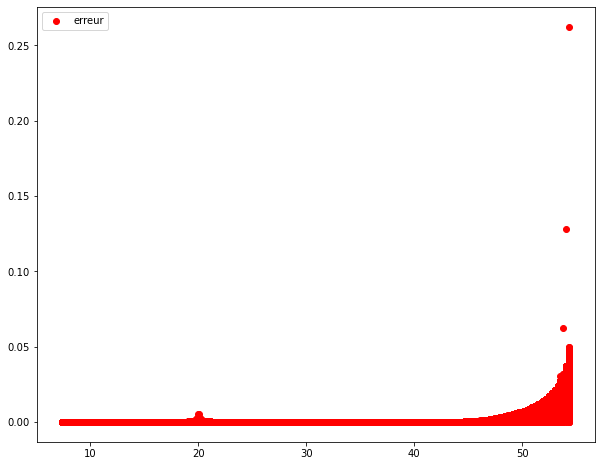

In [17]:
fig = plt.figure(figsize=(10,8))
plt.scatter(SX,abs(V_explicite-analytique),c="red", label="erreur")
plt.legend(loc="upper left")

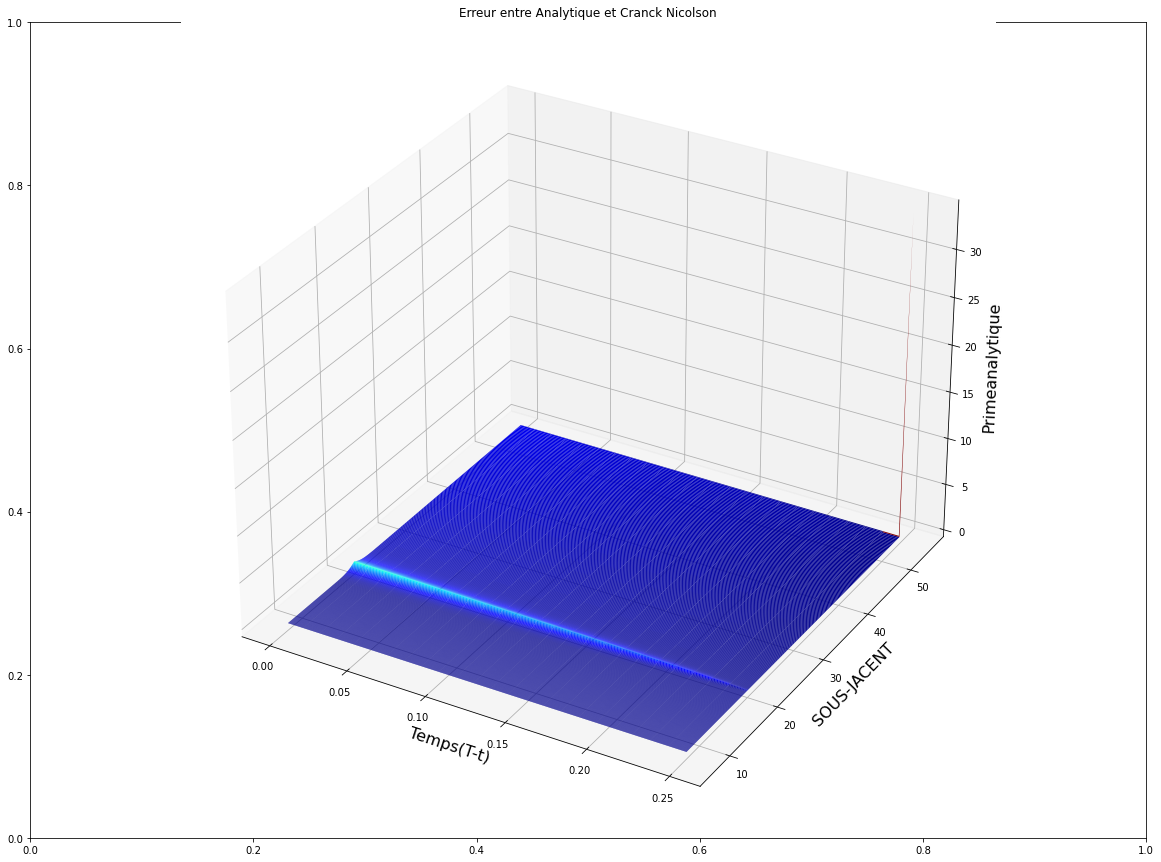

In [18]:
fig = plt.figure(figsize=(20,15))

plt.title("Erreur entre Analytique et Cranck Nicolson")

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Temps(T-t)', fontsize = 16)
ax.set_ylabel('SOUS-JACENT', fontsize = 16)
ax.set_zlabel('Primeanalytique', fontsize = 16)

p = ax.plot_surface(ST,SX,analytique-V_Cranck,cstride=1,linewidth=0,cmap='jet')


# Test pour le calcul de rapidité

In [19]:
#N=400
#M=100
#rapport=2>CFL


In [20]:
import timeit
import time

t1 = time.time()
Uexplicite=eulerexplicite(x,M,N)
t2 = time.time()
t2-t1

0.008027315139770508

In [21]:
t1 = time.time()
Uimplicte=eulerimplicite(x,M,N)
t2 = time.time()
t2-t1

2.775373935699463

In [22]:
t1 = time.time()
Ucranck=crancknicolson(x,M,N) 
t2 = time.time()
t2-t1

0.48400068283081055